# Cube in a Box

### Visualizing Data


The [OpenDatacube](https://github.com/opendatacube) provides an integrated gridded data analysis environment capable of delivering decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

Cube in a box is an easy to install implementation of the OpenDataCube that provides small case study notebook examples of the open datacubes capabilities.



Cube in a box automatically indexes the landsat path/rows stored in Amazon's [Landsat archive](https://registry.opendata.aws/landsat-8)  associated with the extent specified in the 'cube in a box' config file. This notebook demonstrates how to load a specific time slice and visualise sensor bands and also how to do a pixel drill.

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to demonstrate functionality.

In [1]:
%matplotlib inline
import datacube #Load the datacube library
import folium
import datetime
from utils.utils import threeBandImage
from utils.utils import loadConfigExtent
from utils.utils import transformToWGS


Let's first explore the extent area that had been specified in the config file. 
Zoom in to the red bounding box in the below map to confirm this is the extent that you're looking to experiment explore. If the config parameters have been set correctly there will be a bounding box over your case study area, if the bounding box is in the right location then Cube in a Box has indexed all relavent Landsat 8 path/rows corresponding the extent.

In [2]:
extent, boundingBox = loadConfigExtent()
m = folium.Map(zoom_start = 1)
folium.PolyLine(boundingBox, color = 'red').add_to(m)
m

In [3]:
#Creating an instance of the datacube.
dc = datacube.Datacube(app='dc-visualize')

In the sample below we load the RGB bands of an extent covering the southern tip of Tasmanaia, Australia. Landsat images on AWS are referenced to WGS 84 so the extent bounds that are entered into the datacube.load() must match the coordinate system in which they're being stored. 

The datacube.load() command also reprojects into a coordinate system of choice as in the below example in which we've specified epsg - 28355 which corresponds to GDA94 Zone 55.

If you'd like to choose your own case-study area make sure you enter an appropriate epsg code.

If you'd like to visualize other bands add any of the below measurements,

Landsat 8 measurement options are:

             ('1', 'coastal_aerosol')
             ('2', 'blue')
             ('3', 'green')
             ('4', 'red')
             ('5', 'nir')
             ('6', 'swir1')
             ('7', 'swir2')
             ('8', 'panchromatic')
             ('9', 'cirrus')
             ('10', 'lwir1')
             ('11', 'lwir2')
             ('QUALITY', 'quality')]


In [4]:
%%time
date_range = (datetime.datetime(2017,3,12),datetime.datetime(2017,3,14))
ds = dc.load(product='ls8_level1_usgs', x=(extent[0],extent[1]), y=(extent[2],extent[3]), 
             output_crs = 'epsg:28355', resolution = (-30,30), time = date_range, 
             measurements = ('red','green','blue'))

CPU times: user 1.73 s, sys: 1.05 s, total: 2.78 s
Wall time: 1min 57s


The datacube.load() returns an [xarray](https://xarray.pydata.org/en/stable/), to understand how to query a datacube it is important to understand the xarray. Click on the documention to find out more, otherwise a number of examples are provided below.

The xarray for landsat contains the dimensions of X,Y and Time - for each combination of these dimensions data listed as "Data Variables" can be retrieved. 

In [5]:
print (ds) #viewing the data

<xarray.Dataset>
Dimensions:  (time: 1, x: 1439, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
Data variables:
    red      (time, y, x) int16 15800 14191 12983 11002 10106 10130 9190 ...
    green    (time, y, x) int16 15415 13831 12980 11105 10315 10151 9334 ...
    blue     (time, y, x) int16 15732 14344 13446 11655 11022 10969 10156 ...
Attributes:
    crs:      epsg:28355


In [7]:
#Query xarray using index, as any python array 0 will retrieve the first record of each dimension
print (ds.isel(time = [0], x = [0], y=[0])) 


<xarray.Dataset>
Dimensions:  (time: 1, x: 1, y: 1)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06
  * x        (x) float64 4.431e+05
Data variables:
    red      (time, y, x) int16 15800
    green    (time, y, x) int16 15415
    blue     (time, y, x) int16 15732
Attributes:
    crs:      epsg:28355


In [8]:
#Extract all y measurements between x = 443200 and x = 443500
print (ds.sel(x = [443200,443500],  method='nearest')) 


<xarray.Dataset>
Dimensions:  (time: 1, x: 2, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.432e+05 4.435e+05
Data variables:
    red      (time, y, x) int16 11002 11379 12130 9983 10936 8437 9698 7716 ...
    green    (time, y, x) int16 11105 11445 11902 10185 10893 8791 9912 8158 ...
    blue     (time, y, x) int16 11655 12057 12569 10918 11768 9607 10670 ...
Attributes:
    crs:      epsg:28355


Next we'll display the RGB bands that we have extracted from our cube for the first time slice (time = 0), in order to visualise a comprehendible RGB image we apply a histogram equalisation on each band before displaying.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figsize', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


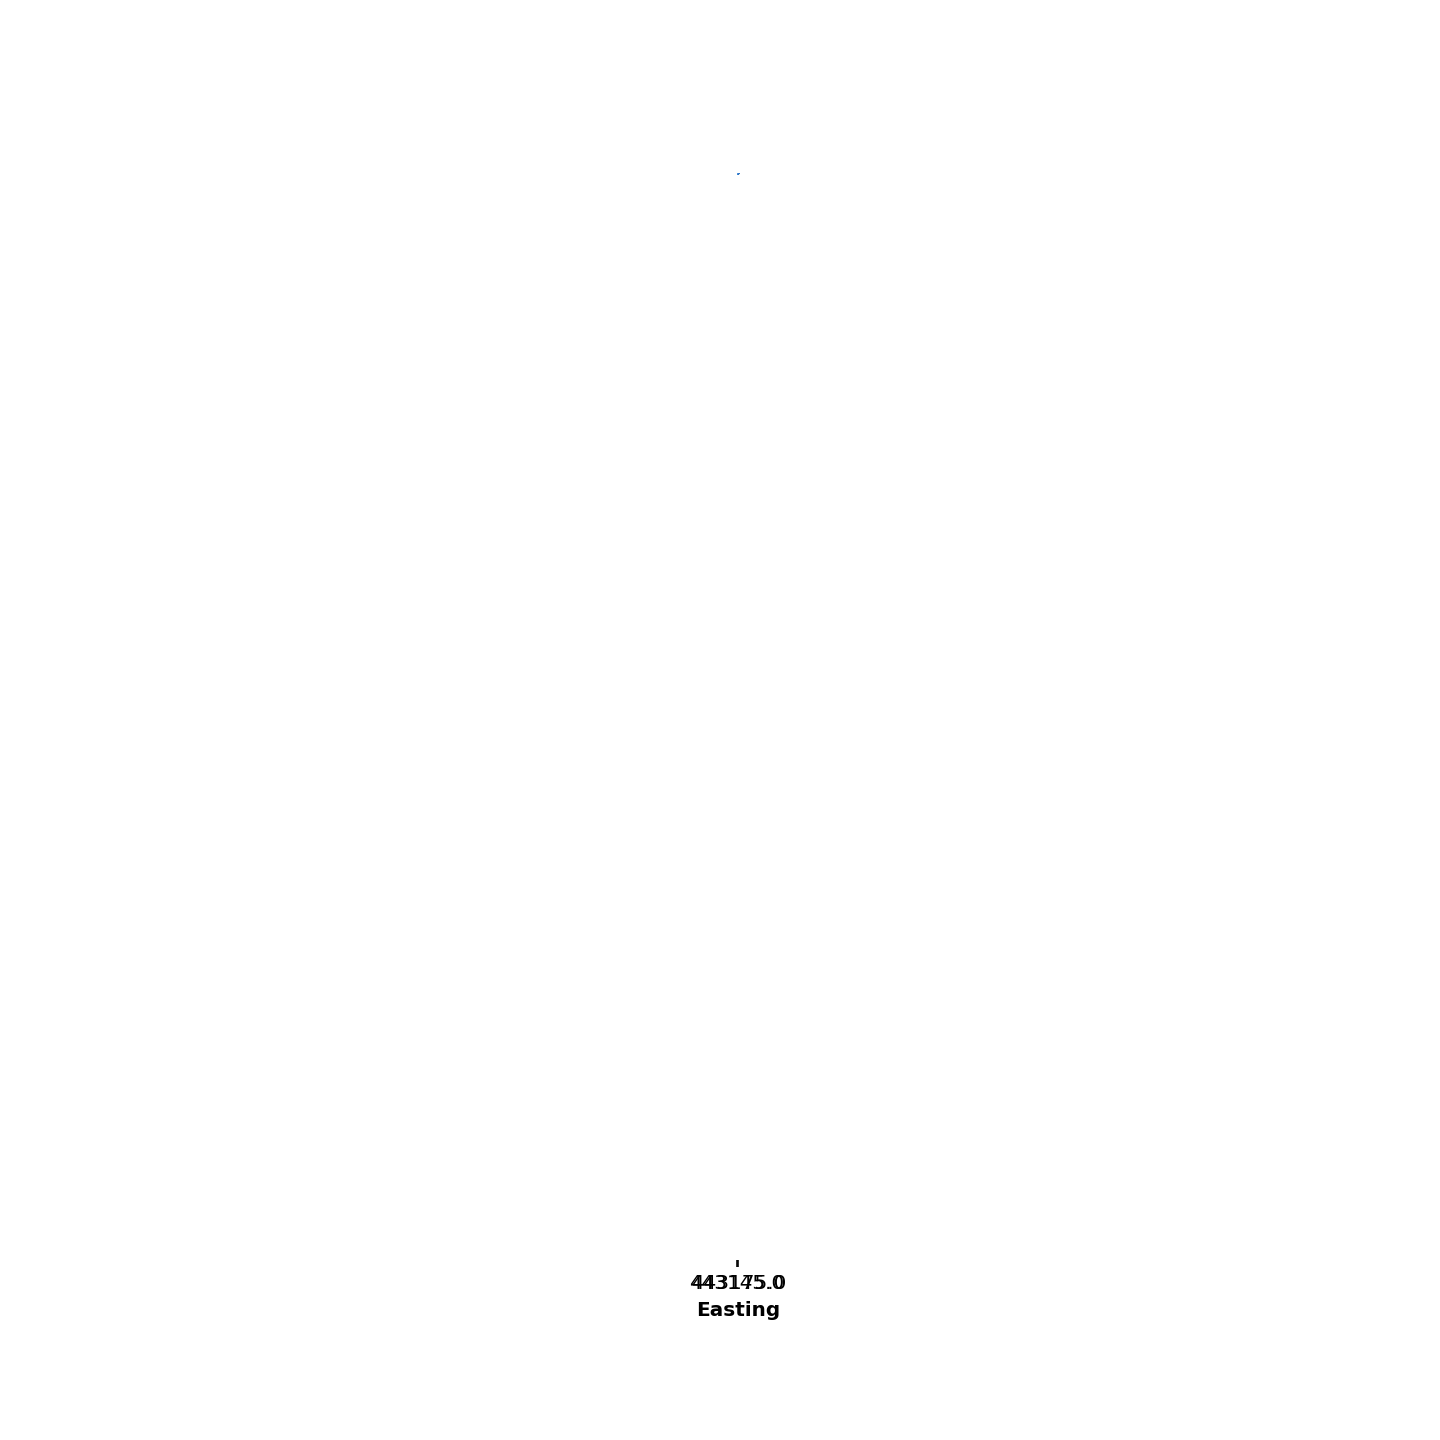

Text(0,0.5,'Northing')

In [11]:
%pylab notebook
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)

figsize = [10,10]
time = 0
img_toshow = threeBandImage(ds,bands = ['red', 'green', 'blue'], time = time)
fig = plt.figure(figsize = figsize)
fig.canvas.mpl_connect('button_press_event', callback)

imshow(img_toshow)
ax = plt.gca()
ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')

Next we'll select a single pixel from the above image and drill through the time dimension to calculate the change in nDVI and quality of the measurements.

To select a pixel simply click on the image above and run the below cell.

In [15]:
pixelDrillExtent = []
for i in [[x,y],[x+1,y+1]]:
    xI,yI = i
    getLong = ds.isel(x=[xI], y=[yI]).isel(time =0).x.values
    getLat = ds.isel(x=[xI], y=[yI]).isel(time =0).y.values
    
    pixelDrillExtent.append(transformToWGS(getLong, getLat,28355))
print pixelDrillExtent

By expanding out the time extent and limiting the x,y extent in the datacube.load() we are able to retrieve cross section through time.


In [16]:
%%time
date_range = (datetime.datetime(2004,3,12),datetime.datetime(2018,3,14))
ds1 = dc.load(product='ls8_level1_usgs', x=(pixelDrillExtent[0][0],pixelDrillExtent[1][0]), y=(pixelDrillExtent[0][1],pixelDrillExtent[1][1]), 
             output_crs = 'epsg:28355', resolution = (-30,30), time = date_range,measurements = ('red','nir','quality'))



CPU times: user 11.2 s, sys: 10.5 s, total: 21.7 s
Wall time: 36min 56s


In [17]:
print (ds1)

<xarray.Dataset>
Dimensions:  (time: 46, x: 2, y: 2)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-03T23:58:42.374786 ...
  * y        (y) float64 5.184e+06 5.184e+06
  * x        (x) float64 4.521e+05 4.521e+05
Data variables:
    red      (time, y, x) int16 6966 6670 6578 6602 6883 6459 6457 6144 ...
    nir      (time, y, x) int16 9836 9250 9107 9169 9888 8463 8477 7160 ...
    quality  (time, y, x) int16 2720 2720 2720 2720 2720 2720 2720 2720 2800 ...
Attributes:
    crs:      epsg:28355


In [27]:
pixeldrill = ds1.isel(x = [0], y = [0])

ndvi = (pixeldrill.nir.values-pixeldrill.red.values)/(pixeldrill.nir.values+pixeldrill.red.values)

ds1['ndvi'] = (('time', 'y','x'), ndvi)
#print (ds1)

ValueError: conflicting sizes for dimension 'y': length 1 on 'ndvi' and length 2 on 'y'

In [32]:
print (np.ravel(np.ravel(ds1.time.values)))

['2017-03-03T23:58:42.374786000' '2017-03-12T23:52:26.445797000'
 '2017-03-19T23:58:32.578365000' '2017-03-28T23:52:17.421083000'
 '2017-04-04T23:58:25.273927000' '2017-04-13T23:52:09.723344000'
 '2017-04-20T23:58:16.094869000' '2017-04-29T23:51:59.246143000'
 '2017-05-15T23:52:08.150718000' '2017-05-22T23:58:23.628150000'
 '2017-05-31T23:52:17.881629000' '2017-06-07T23:58:31.964484000'
 '2017-06-16T23:52:24.608516000' '2017-06-23T23:58:37.540113000'
 '2017-07-02T23:52:28.719769000' '2017-07-09T23:58:40.613258000'
 '2017-07-18T23:52:33.198259000' '2017-07-25T23:58:47.595175000'
 '2017-08-03T23:52:40.722615000' '2017-08-10T23:58:54.091037000'
 '2017-08-19T23:52:45.898011000' '2017-08-26T23:58:58.123706000'
 '2017-09-04T23:52:48.321793000' '2017-09-11T23:58:58.997265000'
 '2017-09-20T23:52:51.394624000' '2017-09-27T23:59:05.388613000'
 '2017-10-06T23:52:57.538197000' '2017-10-13T23:59:09.791397000'
 '2017-10-22T23:52:59.886480000' '2017-10-29T23:59:10.525530000'
 '2017-11-07T23:52:58.452

<IPython.core.display.Javascript object>


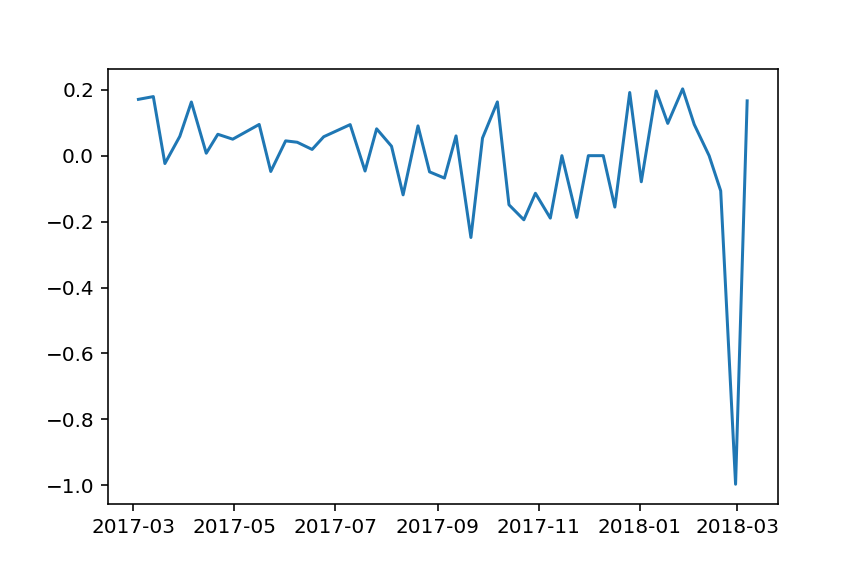

In [35]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.plot(np.ravel(ds1.time.values),np.ravel(ndvi))
plt.axis = 'NDVI'
plt.show()